In [1]:
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet201
from keras.applications.xception import Xception
from keras.optimizers import Adam
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import sys
import cv2

train_path='training_set/'
test_path='testing_set/'
valid_path='valid_set/'

img_height, img_width, img_channel = 299, 299, 3
batch_size = 16
aug_ratio = 1
epochs = 100

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# -*- coding: utf-8 -*-
import keras.applications as app


def get_model(name='vgg16',include_top=True,input_shape=None):
    if name == 'vgg16':
        model = app.vgg16.VGG16(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.vgg16.preprocess_input
    if name == 'vgg19':
        model = app.vgg19.VGG19(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.vgg19.preprocess_input
    if name == 'resnet50':
        model = app.resnet50.ResNet50(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.resnet50.preprocess_input
    if name == 'inception_v3':
        model = app.inception_v3.InceptionV3(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.inception_v3.preprocess_input
    if name == 'xception':
        model = app.xception.Xception(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.xception.preprocess_input
    if name == 'mobilenet':
        model = app.mobilenet.MobileNet(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.mobilenet.preprocess_input
    if name == 'densenet':
        model = app.densenet.DenseNet121(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.densenet.preprocess_input

    return model, preprocess_input

In [3]:
classmap_df  = pd.read_csv("classmap.csv")
classmap_df

,classname,classnum
0,rika,0
1,risa,1
2,yui,2
3,akane,3
4,neru,4


In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    fill_mode='nearest',
    validation_split=0)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0)


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes = classmap_df.classname.tolist(),
    class_mode='categorical',
    shuffle=True,
    seed=80) # set as training data

validation_generator = train_datagen.flow_from_directory(
    valid_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes = classmap_df.classname.tolist(),
    class_mode='categorical',
    shuffle=False,
    seed=80)

# validation_generator = train_datagen.flow_from_directory(
#     train_path, 
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     classes = classmap_df.classname.tolist(),
#     class_mode='categorical',
#     shuffle=True,
#     seed=80,    
#     subset='validation') 

Found 432 images belonging to 5 classes.
Found 106 images belonging to 5 classes.


In [5]:
model_name = 'xception'

base_model, preprocess_input = get_model(name=model_name,
                                         include_top=False,
                                        input_shape=(img_height, img_width, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [6]:
model_path = './{}.h5'.format(model_name)

optimizer = Adam(lr=10e-6)
#optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
#optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])


steps_per_epoch = int(aug_ratio * train_generator.samples / train_generator.batch_size)
validation_steps = int(aug_ratio * validation_generator.samples / validation_generator.batch_size)
model_history = model.fit_generator(train_generator,
                                    epochs = epochs,
                                    validation_data = validation_generator,
                                    callbacks = [checkpoint, earlystop,learning_rate_reduction],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/100
27/27 [==============================] - 19s 708ms/step - loss: 1.7058 - acc: 0.2130 - val_loss: 1.6332 - val_acc: 0.1415

Epoch 00001: val_loss improved from inf to 1.63317, saving model to ./xception.h5
Epoch 2/100
27/27 [==============================] - 11s 394ms/step - loss: 1.6665 - acc: 0.2245 - val_loss: 1.6125 - val_acc: 0.2264

Epoch 00002: val_loss improved from 1.63317 to 1.61246, saving model to ./xception.h5
Epoch 3/100
27/27 [==============================] - 12s 439ms/step - loss: 1.6777 - acc: 0.2245 - val_loss: 1.6013 - val_acc: 0.2453

Epoch 00003: val_loss improved from 1.61246 to 1.60126, saving model to ./xception.h5
Epoch 4/100
27/27 [==============================] - 13s 465ms/step - loss: 1.6280 - acc: 0.2477 - val_loss: 1.5897 - val_acc: 0.2925

Epoch 00004: val_loss improved from 1.60126 to 1.58971, saving model to ./xception.h5
Epoch 5/100
27/27 [==============================] - 13s 464ms/step - loss: 1.6361 - acc: 0.2315 - val_loss: 1.5776 - va

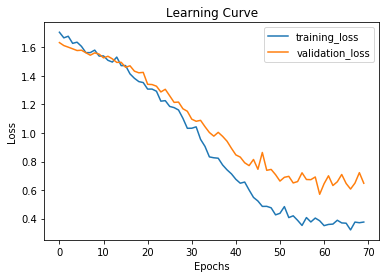

In [7]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

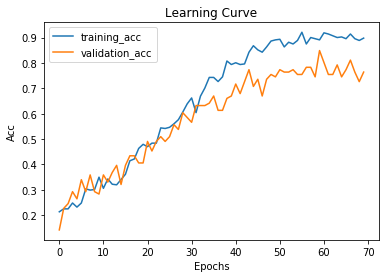

In [8]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [9]:
STEP_SIZE_VALID=validation_generator.samples//validation_generator.batch_size
model.evaluate_generator(generator=validation_generator,steps=STEP_SIZE_VALID)

[0.6632789671421051, 0.78125]